In [1]:
# Installs this package locally so we can import it like any other module (see below).
!pip install -e ..

Obtaining file:///Users/Apex/Desktop/MIDS/w251/ucb_mids_w251_project
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Attempting uninstall: mids-plane-classification
    Found existing installation: mids-plane-classification 0.0.1
    Uninstalling mids-plane-classification-0.0.1:
      Successfully uninstalled mids-plane-classification-0.0.1
  Running setup.py develop for mids-plane-classification


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mids_plane_classification.models.resnet18 import AircraftResNet18
from mids_plane_classification.loaders.dataloader import PlaneDataModule

In [3]:
# Instantiate the custom model.
model = AircraftResNet18()

# Load from the checkpoint.
checkpoint = torch.load("../mids_plane_classification/models/checkpoints/model_best.pth.tar", map_location=torch.device('cpu'))

# Load from the state dict.
model.load_state_dict(checkpoint['state_dict'])

# Set model to evaluation mode.
model.eval()

AircraftResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplac

In [4]:
dm = PlaneDataModule(train_batch_size=32, val_batch_size=32, data_dir='../data', seed=2)
dm.prepare_data()
dm.setup()

## Test Model 1 Image

In [5]:
img_idx = 50
classes = dm.dataset.classes

# Obtain the test entry.
test_data = dm.val_dataset[img_idx]

# Image is at index 0.
test_image = torch.unsqueeze(torch.Tensor(test_data[0].numpy()), dim=0)

# Label is at index 1.
test_label = classes[test_data[1]]

# Argmax returns the index with greatest probability.
prediction = classes[torch.argmax(model(test_image))]

print(f'Prediction: {prediction}, Answer: {test_label}')

Prediction: B-1, Answer: B-1


In [6]:
classes

['B-1',
 'B-2',
 'B-52',
 'Boeing',
 'C-130',
 'C-17',
 'C-5',
 'E-3',
 'F-22',
 'KC-10',
 'KC-135']

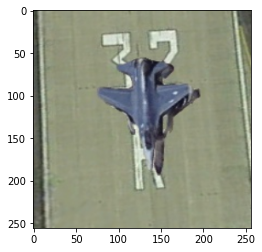

In [7]:
# View the image.
image = np.transpose(dm.train_dataset[img_idx][0].numpy(), (1, 2, 0))
plt.imshow(image)

## Test Model 1 Image

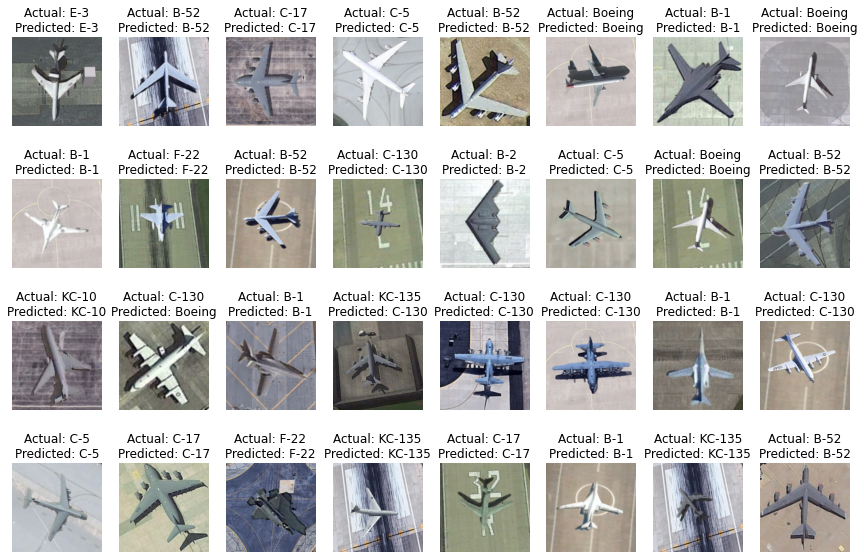

In [8]:
image_count = 32

# Get images as tensors for prediction.
tensor_images = [
    torch.unsqueeze(torch.Tensor(dm.val_dataset[idx][0].numpy()), dim=0)
    for idx in range(image_count)
]

# Get images in a format expected by matplotlib for visualizing.
images = [
    np.transpose(dm.val_dataset[idx][0].numpy(), (1, 2, 0))
    for idx in range(image_count)
]

# Make predictions on the tensors.
predictions = [
    torch.argmax(model(image)) for image in tensor_images
]

# Get labels for the respective indicies.
actuals = [
    dm.val_dataset[idx][1]
    for idx in range(image_count)
]

fig, axes = plt.subplots(nrows=4, ncols=8)
fig.set_figheight(10)
fig.set_figwidth(15)
axes = axes.flatten()

for ax, image, actual, prediction in zip(axes, images, actuals, predictions):
    prediction_label = classes[prediction]
    actual_label = classes[actual]
    ax.imshow(image)
    ax.set_title(f'Actual: {actual_label}\nPredicted: {prediction_label}')
    ax.axis('off')

## Using Inference Engine

In [11]:
import numpy as np
from PIL import Image
from mids_plane_classification.inference import Engine, ModelType

# Input will likely be a bytes object, we'll need to convert that to a numpy ndarray later.
img = np.array(Image.open('../res/test_image.png').convert('RGB'))

# Simple instantiation of the model.
engine = Engine(ModelType.RESNET18)

# Inference engine should handle resizing, tensor conversion, etc.
index, label = engine.predict(img)

print(index, label)

tensor(8) F-22
